In [1]:
import smart_open
from smart_open.compression import (
    _handle_zstd,
    register_compressor,
)
import itertools
import json
import pandas as pd
from tqdm import tqdm
import boto3
import seaborn as sns
import matplotlib.pyplot as plt
import wandb

api = wandb.Api()
register_compressor(".zstd", _handle_zstd)

In [23]:
sources_sizes = {
    "gutenberg_books": 2_627_896_053,
    "pes20_stem_papers": 28_604_876_365,
    "wikipedia_wikibooks": 3_689_204_524,
    "megawika": 2_281_051_092,
    "stackexchange": 9_814_791_671,
    "arxiv": 13_986_831_288,
    "algebraic_stack": 6_311_288_265,
    "openwebmath": 6_367_150_300,
    "tulu": 8_268_453_782,
    "cc_news": 7_130_708_273,
    "starcoder": 131_887_652_399,
    "c4_debug": 827_856_324,
    "c4": 69_220_588_954,
    "reddit": 39_972_006_511,
    "falcon": 228_202_479_465,
    "web_rest": 299_211_329_457,
    "all_red_pajama": 625_652_417_451,
    "cc_eli5_oh_top10p": 51_306_739_746,
    "falcon_eli5_oh_top10p": 21_730_127_205,
    "cc_eli5_oh_top20p": 83_234_747_123,
    "falcon_eli5_oh_top20p": 59_690_132_487,
    "cc_og_eli5_oh_top10p": 49_047_630_489,
    "falcon_og_eli5_oh_top10p": 24_874_205_085,
    "prox_fineweb_pro": 41_361_594_483,
    "fineweb_edu_dedup": 96_100_913_800,
    "cc_tulu_qc_top10": 41_843_452_876,
    "falcon_tulu_qc_top10": 22_614_162_276,
    "pos_eli5_oh_neg_dclm_refinedweb_steps_2000_lr3e4_top10p": 41_037_912_102,
    "pos_eli5_oh_neg_dclm_refinedweb_steps_2000_lr3e4_top20p": 85_531_708_515,
    "regression_synthetic_20epochs_bs640_lf1_lre35_top10p": 53_320_429_656,
    "regression_synthetic_20epochs_bs640_lf1_lre35_top20p": 124_365_177_166,
    "dclm_fw_top10": 49_232_730_070,
    "dclm_ft7percentile_fw3": 108_986_400_784,
    "dclm_mmlu_top10": 49_939_303_843,
    "dclm_mmlu_top3": 63_465_963_452,
    "dclm_fw_top3": 59_044_721_273
}

In [27]:
mixtures = {
    "no_math": ['gutenberg_books', 'wikipedia_wikibooks', 'megawika', 'stackexchange', 'arxiv', 'tulu', 'cc_news', 'starcoder', 'c4', 'reddit', 'falcon', 'web_rest'],
    "no_code": ['gutenberg_books', 'pes20_stem_papers', 'wikipedia_wikibooks', 'megawika', 'arxiv', 'algebraic_stack', 'openwebmath', 'tulu', 'cc_news', 'c4', 'reddit', 'falcon', 'web_rest'],
    "no_math_no_code": ['gutenberg_books', 'wikipedia_wikibooks', 'megawika', 'arxiv', 'tulu', 'cc_news', 'c4', 'reddit', 'falcon', 'web_rest'],
    "no_reddit": ['gutenberg_books', 'pes20_stem_papers', 'wikipedia_wikibooks', 'megawika', 'stackexchange', 'arxiv', 'algebraic_stack', 'openwebmath', 'tulu', 'cc_news', 'starcoder', 'c4', 'falcon', 'web_rest'],
    "no_flan": ['gutenberg_books', 'pes20_stem_papers', 'wikipedia_wikibooks', 'megawika', 'stackexchange', 'arxiv', 'algebraic_stack', 'openwebmath', 'cc_news', 'starcoder', 'c4', 'reddit', 'falcon', 'web_rest'],
    "dolma17": ['gutenberg_books', 'pes20_stem_papers', 'wikipedia_wikibooks', 'megawika', 'stackexchange', 'arxiv', 'algebraic_stack', 'openwebmath', 'tulu', 'cc_news', 'starcoder', 'c4', 'reddit', 'falcon', 'web_rest'],
    "dolma17_debug": ['c4_debug'],
    "redpajama": ["all_red_pajama"],
    "falcon": ["falcon"],
    "falcon_and_cc": ["falcon", "web_rest"],
    "c4": ["c4"],
    "prox_fineweb_pro": ["prox_fineweb_pro"],
    "fineweb_edu_dedup": ["fineweb_edu_dedup"],
    "falcon_and_cc_eli5_oh_top10p": ["cc_eli5_oh_top10p", "falcon_eli5_oh_top10p"],
    "falcon_and_cc_eli5_oh_top20p": ["cc_eli5_oh_top20p", "falcon_eli5_oh_top20p"],
    "falcon_and_cc_og_eli5_oh_top10p": ["cc_og_eli5_oh_top10p", "falcon_og_eli5_oh_top10p"],
    "falcon_and_cc_tulu_qc_top10": ["cc_tulu_qc_top10", "falcon_tulu_qc_top10"],
    "pos_eli5_oh_neg_dclm_refinedweb_steps_2000_lr3e4_top10p": ["pos_eli5_oh_neg_dclm_refinedweb_steps_2000_lr3e4_top10p"],
    "pos_eli5_oh_neg_dclm_refinedweb_steps_2000_lr3e4_top20p": ["pos_eli5_oh_neg_dclm_refinedweb_steps_2000_lr3e4_top20p"],
    "regression_synthetic_20epochs_bs640_lf1_lre35_top10p": ["regression_synthetic_20epochs_bs640_lf1_lre35_top10p"],
    "regression_synthetic_20epochs_bs640_lf1_lre35_top20p": ["regression_synthetic_20epochs_bs640_lf1_lre35_top20p"],
    "dclm_mmlu_top10": ["dclm_mmlu_top10"],
    "dclm_fw_top10": ["dclm_fw_top10"],
    # "dclm_ft7percentile_fw2": ["dclm_ft7percentile_fw2"],
    # "dclm_ft7percentile_fw3": ["dclm_ft7percentile_fw3"],
    "dolma17_uniform": ['gutenberg_books', 'pes20_stem_papers', 'wikipedia_wikibooks', 'megawika', 'stackexchange', 'arxiv', 'algebraic_stack', 'openwebmath', 'tulu', 'cc_news', 'starcoder', 'c4', 'reddit', 'falcon', 'web_rest'],
    # "DCLM-baseline": ["DCLM-baseline"],
}

In [28]:
# Calculate the total size for each mixture
mixture_sizes = {mixture: sum(sources_sizes[source] for source in sources) for mixture, sources in mixtures.items()}

# Calculate the proportion of each data source within each mixture
mixture_proportions = {
    mixture: {source: sources_sizes[source] / mixture_sizes[mixture] for source in sources}
    for mixture, sources in mixtures.items()
}

# Print the resulting dictionary
mixture_proportions

{'no_math': {'gutenberg_books': 0.0032193049236307067,
  'wikipedia_wikibooks': 0.00451946121492724,
  'megawika': 0.002794402390134721,
  'stackexchange': 0.012023613763104941,
  'arxiv': 0.0171345722674406,
  'tulu': 0.010129272023837366,
  'cc_news': 0.008735476514010774,
  'starcoder': 0.16156901192856882,
  'c4': 0.08479870525389822,
  'reddit': 0.04896771971682739,
  'falcon': 0.2795595224886202,
  'web_rest': 0.36654893751499906},
 'no_code': {'gutenberg_books': 0.00367089257471799,
  'pes20_stem_papers': 0.039957983927534226,
  'wikipedia_wikibooks': 0.005153428149605587,
  'megawika': 0.0031863868841448283,
  'arxiv': 0.01953812254496828,
  'algebraic_stack': 0.008816201539800131,
  'openwebmath': 0.008894234888667198,
  'tulu': 0.01155015456493883,
  'cc_news': 0.009960844540237164,
  'c4': 0.09669383449119429,
  'reddit': 0.05583666132086886,
  'falcon': 0.3187747043662473,
  'web_rest': 0.4179665502070753},
 'no_math_no_code': {'gutenberg_books': 0.0038955423483789105,
  'w

In [7]:
paths = {
    "DCLM-baseline": "s3://ai2-benb/corpus_scores/dclm/attributes/regression-mmlu-20epochs/100b/",
    "c4": "s3://ai2-benb/corpus_scores/c4/attributes/regression-mmlu-20epochs/",
    "falcon": "s3://ai2-benb/corpus_scores/falcon-refinedweb/attributes/regression-mmlu-20epochs/",
    "fineweb_edu_dedup": "s3://ai2-benb/corpus_scores/fineweb_edu_dedup/attributes/regression-mmlu-20epochs/",
    "prox_fineweb_pro": "s3://ai2-benb/corpus_scores/prox_fineweb_pro/attributes/regression-mmlu-20epochs/",
}

# Function to list all files in a given S3 prefix
def list_s3_files(bucket, prefix):
    s3 = boto3.client('s3')
    paginator = s3.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=bucket, Prefix=prefix)
    
    files = []
    for page in pages:
        if 'Contents' in page:
            for obj in page['Contents']:
                files.append(f"s3://{bucket}/{obj['Key']}")
    return files

In [10]:
paths = {   'algebraic_stack': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/proof-pile-2/v0_decontaminated/documents/algebraic-stack/train',
    'all_red_pajama': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/redpajama/v1',
    'arxiv': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/redpajama/v1_decon_fix/documents/train/arxiv',
    'c4': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/c4/v1_7-dd_ngram_dp_030-qc_cc_en_bin_001-fix',
    'c4_debug': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/c4/v1_7-dd_ngram_dp_030-qc_cc_en_bin_001-fix',
    'cc_eli5_oh_top10p': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/olmo-mix/eli5_oh_top10p',
    'cc_eli5_oh_top20p': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/olmo-mix/eli5_oh_oh_top20p',
    'cc_news': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/cc-news/v3',
    'cc_og_eli5_oh_top10p': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/olmo-mix/og_eli5_oh_top10p',
    'cc_tulu_qc_top10': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/olmo-mix/tulu_qc_top10',
    'dclm_fw_top10': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/dclm/v0_fw_top10p',
    'dclm_mmlu_top10': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/dclm/regression_synthetic_mmlu_10p/documents/1t',
    'falcon': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/falcon-refinedweb/v2-frac_005_100-qc_cc_multi_bin-paloma-rep-pii',
    'falcon_eli5_oh_top10p': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/falcon-refinedweb/eli5_oh_top10p',
    'falcon_eli5_oh_top20p': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/falcon-refinedweb/eli5_oh_oh_top20p/documents/',
    'falcon_og_eli5_oh_top10p': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/falcon-refinedweb/og_eli5_oh_top10p',
    'falcon_tulu_qc_top10': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/falcon-refinedweb/tulu_qc_top10',
    'fineweb_edu_dedup': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/fineweb-edu-dedup/v0',
    'gutenberg_books': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/olmo-mix/v1_6-decontaminated/documents/books',
    'megawika': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/megawika/v1',
    'openwebmath': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/proof-pile-2/v0_decontaminated/documents/algebraic-stack/train',
    'pes20_stem_papers': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/olmo-mix/v1_6-decontaminated/documents/pes2o',
    'pos_eli5_oh_neg_dclm_refinedweb_steps_2000_lr3e4_top10p': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/dclm/pos_eli5_oh_neg_dclm_refinedweb_steps_2000_lr3e4_top10p/documents/1t',
    'prox_fineweb_pro': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/prox_fineweb_pro/v0',
    'reddit': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/reddit/v5-dedupe-pii-nsfw-toxic-fuzzydd-length',
    'regression_synthetic_20epochs_bs640_lf1_lre35_top10p': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/dclm/regression_synthetic_20epochs_bs640_lf1_lre35_top10p/documents/1t',
    'regression_synthetic_20epochs_bs640_lf1_lre35_top20p': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/dclm/regression_synthetic_20epochs_bs640_lf1_lre35_top20p/documents/1t',
    'stackexchange': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/redpajama/v1_decon_fix/documents/train/stackexchange',
    'starcoder': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/starcoder/v0_decontaminated_doc_only',
    'tulu': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/tulu_flan/v2-decontaminated-60M-shots_all-upweight_1-dialog_false-sep_newline/documents/train',
    'web_rest': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/olmo-mix/v1_7-dd_ngram_dp_030-qc_cc_en_bin_001/documents/cc_en_tail',
    'wikipedia_wikibooks': 's3://ai2-benb/corpus_scores/regression-mmlu-20epochs/olmo-mix/v1_6-decontaminated/documents/wiki'}


In [3]:

metrics = [
    "eval/downstream/mmlu_humanities_var_len_norm",
    "eval/downstream/mmlu_other_var_len_norm",
    "eval/downstream/mmlu_stem_var_len_norm",
    "eval/downstream/mmlu_social_sciences_var_len_norm",
]


# Create a list to store the data
data = []

# Iterate over each path and load the corresponding wandb run
for name in paths.keys():
    run_name = f"{name}-1B-5xC"
    runs = api.runs("ai2-llm/olmo-ladder-benb", {"display_name": run_name}, order="-created_at")
    
    if len(runs) == 0:
        run_name = f"{name}-1B-5xC-2"
        runs = api.runs("ai2-llm/olmo-ladder-benb", {"display_name": run_name}, order="-created_at")
    if len(runs) == 0:
        print(f"No runs found for {run_name}")
        continue
    
    for run in runs:
        run_data = {"name": name}
        for metric in metrics:
            run_data[metric] = run.summary.get(metric)
        data.append(run_data)
        
        break

# Create a DataFrame from the collected data
performance_df = pd.DataFrame(data)

# add an average column
performance_df['average'] = performance_df[metrics].mean(axis=1)

performance_df

,name,eval/downstream/mmlu_humanities_var_len_norm,eval/downstream/mmlu_other_var_len_norm,eval/downstream/mmlu_stem_var_len_norm,eval/downstream/mmlu_social_sciences_var_len_norm,average
0,DCLM-baseline,0.304192,0.435412,0.295950,0.376431,0.352996
1,c4,0.266685,0.412475,0.253227,0.294616,0.306751
2,falcon,0.286266,0.405231,0.283489,0.328105,0.325773
3,fineweb_edu_dedup,0.339217,0.457545,0.286159,0.401441,0.371091
4,prox_fineweb_pro,0.313293,0.447887,0.283489,0.372616,0.354321


In [13]:
import concurrent.futures
from tqdm import tqdm

def process_path(name, path):
    bucket = path.split('/')[2]
    prefix = '/'.join(path.split('/')[3:])
    files = list_s3_files(bucket, prefix)

    values = []
    for file in files:
        with smart_open.open(file, 'rb') as fin:
            for line in itertools.islice(fin, None):
                attributes_dict = json.loads(line)["attributes"]
                assert len(attributes_dict) == 1
                attributes = list(attributes_dict.values())[0][0]
                value = attributes[2]
                values.append(value)
    return name, values

values = {}
with concurrent.futures.ThreadPoolExecutor(max_workers=32) as executor:
    futures = {executor.submit(process_path, name, path): name for name, path in paths.items()}
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
        name, result = future.result()
        values[name] = result

100%|██████████| 32/32 [11:19<00:00, 21.24s/it]


In [29]:
# create a dataframe with "name", "value" columns
df = pd.DataFrame(
    [(name, value) for name, values in values.items() for value in values],
    columns=["name", "value"]
)

# group and sort by average value
df.groupby("name").mean().sort_values("value", ascending=False)

,value
name,
fineweb_edu_dedup,1.518948
regression_synthetic_20epochs_bs640_lf1_lre35_top10p,1.419180
regression_synthetic_20epochs_bs640_lf1_lre35_top20p,1.320866
pes20_stem_papers,1.303592
pos_eli5_oh_neg_dclm_refinedweb_steps_2000_lr3e4_top10p,1.296481
arxiv,1.199165
all_red_pajama,1.147114
cc_og_eli5_oh_top10p,1.130307
stackexchange,1.095062


In [30]:
# how much values per name
df['name'].value_counts()

name
all_red_pajama                                             200000
wikipedia_wikibooks                                        100000
megawika                                                   100000
prox_fineweb_pro                                           100000
falcon_tulu_qc_top10                                       100000
falcon_og_eli5_oh_top10p                                   100000
pos_eli5_oh_neg_dclm_refinedweb_steps_2000_lr3e4_top10p    100000
falcon_eli5_oh_top10p                                      100000
regression_synthetic_20epochs_bs640_lf1_lre35_top10p       100000
falcon_eli5_oh_top20p                                      100000
regression_synthetic_20epochs_bs640_lf1_lre35_top20p       100000
falcon                                                     100000
cc_eli5_oh_top20p                                          100000
cc_tulu_qc_top10                                           100000
cc_eli5_oh_top10p                                          100000
cc_og

In [31]:
# Compute the weighted average score for each mixture
weighted_average_scores = {}
for mixture, sources in mixtures.items():
    weighted_sum = sum(df.loc[df['name'] == source, 'value'].mean() * mixture_proportions[mixture][source] for source in sources)
    weighted_average_scores[mixture] = weighted_sum

weighted_average_scores

{'no_math': nan,
 'no_code': nan,
 'no_math_no_code': nan,
 'no_reddit': nan,
 'no_flan': nan,
 'dolma17': nan,
 'dolma17_debug': -0.70751953125,
 'redpajama': 1.1471137193721532,
 'falcon': -0.70751953125,
 'falcon_and_cc': 0.03456672143747053,
 'c4': -0.70751953125,
 'prox_fineweb_pro': -0.7080086767578125,
 'fineweb_edu_dedup': 1.5189483211135864,
 'falcon_and_cc_eli5_oh_top10p': 0.9733759066591172,
 'falcon_and_cc_eli5_oh_top20p': 0.9038628234763739,
 'falcon_and_cc_og_eli5_oh_top10p': 1.0324135597533008,
 'falcon_and_cc_tulu_qc_top10': 0.9414962800071265,
 'pos_eli5_oh_neg_dclm_refinedweb_steps_2000_lr3e4_top10p': 1.2964810616278648,
 'pos_eli5_oh_neg_dclm_refinedweb_steps_2000_lr3e4_top20p': nan,
 'regression_synthetic_20epochs_bs640_lf1_lre35_top10p': 1.419180092101097,
 'regression_synthetic_20epochs_bs640_lf1_lre35_top20p': 1.3208656853747367,
 'dclm_mmlu_top10': nan,
 'dclm_fw_top10': nan,
 'dolma17_uniform': nan}

In [32]:
# same but with median
grouped_df = df.groupby("name").median().sort_values("value", ascending=False)

# merge with performance_df
df = grouped_df.merge(performance_df, on="name")

df

,name,value,eval/downstream/mmlu_humanities_var_len_norm,eval/downstream/mmlu_other_var_len_norm,eval/downstream/mmlu_stem_var_len_norm,eval/downstream/mmlu_social_sciences_var_len_norm
0,fineweb_edu_dedup,1.457031,0.339217,0.457545,0.286159,0.401441
1,prox_fineweb_pro,1.208008,0.313293,0.447887,0.283489,0.372616
2,DCLM-baseline,0.728027,0.304192,0.435412,0.295950,0.376431
3,c4,0.587891,0.266685,0.412475,0.253227,0.294616
4,falcon,0.491455,0.286266,0.405231,0.283489,0.328105


In [38]:
# Add a new column to indicate if the value is above 3
df['above_3'] = df['value'] > 2

# Group by name and calculate the proportion of values above 3
proportion_above_3 = df.groupby('name')['above_3'].mean()

# Sort the results
proportion_above_3_sorted = proportion_above_3.sort_values(ascending=False)

proportion_above_3_sorted

name
fineweb_edu_dedup    0.122509
prox_fineweb_pro     0.062839
dclm                 0.026158
c4                   0.010354
falcon               0.007862
Name: above_3, dtype: float64

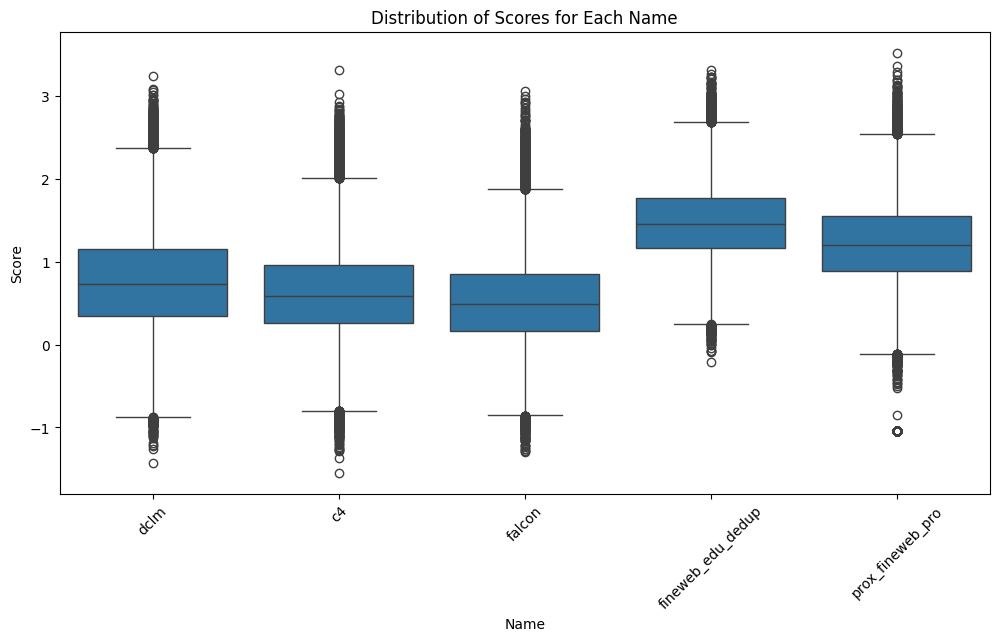

In [39]:

# Create a boxplot to show the distribution of scores for each name
plt.figure(figsize=(12, 6))
sns.boxplot(x='name', y='value', data=df)
plt.title('Distribution of Scores for Each Name')
plt.xlabel('Name')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

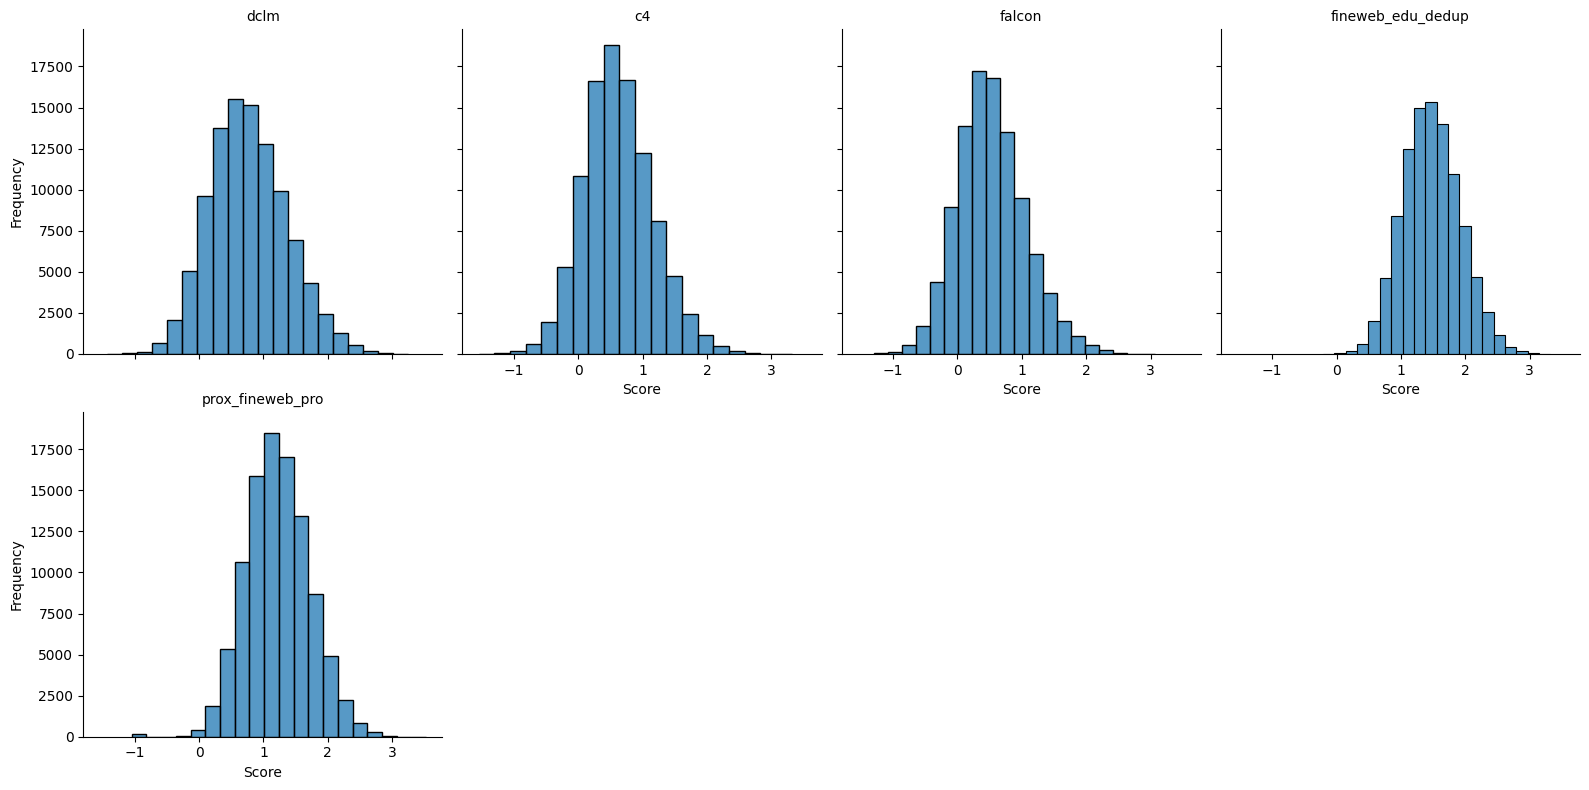

In [41]:
# Create a FacetGrid to show a histogram for each name
g = sns.FacetGrid(df, col="name", col_wrap=4, height=4)
g.map(sns.histplot, "value", bins=20)

# Add titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Score", "Frequency")

plt.show()

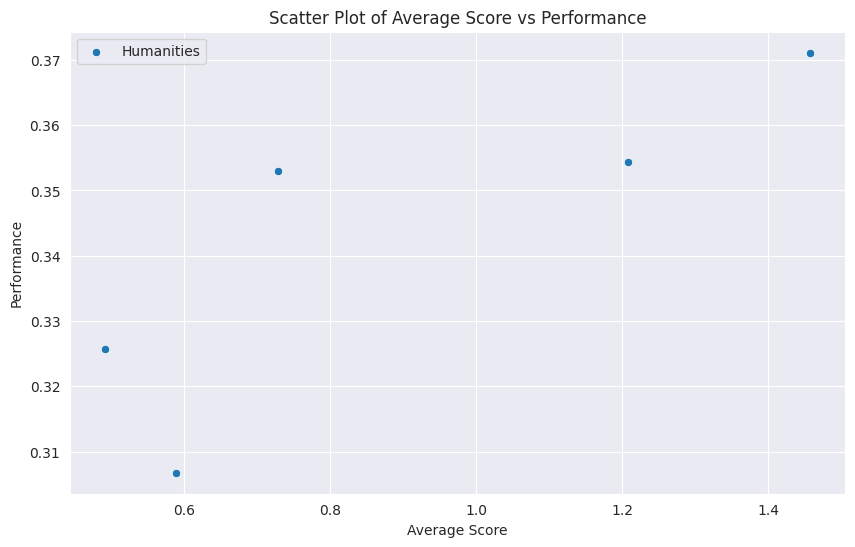

In [37]:
# Calculate the average score for each name
average_scores = df.groupby("name")["value"].mean().reset_index()
average_scores.columns = ["name", "average_score"]

# Merge the average scores with the performance DataFrame
scatter_df = average_scores.merge(performance_df, on="name")

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x="average_score", y="average", data=scatter_df, label="Average MMLU")
# sns.scatterplot(x="average_score", y="eval/downstream/mmlu_other_var_len_norm", data=scatter_df, label="Other")
plt.title("Scatter Plot of Average Score vs Performance")
plt.xlabel("Average Score")
plt.ylabel("Performance")
plt.legend()
plt.show()